<a href="https://colab.research.google.com/github/divsal009/div/blob/master/Brats2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import random as r
from keras.optimizers import Adam

In [30]:
import glob
def create_data(src, mask, label=False, resize=(128,128,128)):
    files = glob.glob(src + mask, recursive=True)
    imgs = []
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        if label:
            img[img == 4] = 1
            img[img != 1] = 0
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()
        img = trans.resize(img, resize, mode='constant')
        imgs.append(img)
    name = 'y' if label else 'x'
    np.save(name, np.array(imgs)[..., np.newaxis].astype('float32'))
    print('Saved', len(files), 'to', name)

In [31]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D, Reshape
from keras.layers import UpSampling2D, Activation, Permute

def level_block(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        m = MaxPooling2D()(n)
        m = level_block(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling2D()(m)
        m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, 3, activation=acti, padding='same')(m)
    return Conv2D(dim, 3, activation=acti, padding='same')(m)

def UNet(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='elu', flatten=False):
    i = Input(shape=img_shape)
    o = level_block(i, dim, depth, factor, acti)
    o = Conv2D(n_out, (1, 1))(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [32]:
from keras.models import Input, Model
from keras.layers import Conv3D, Concatenate, MaxPooling3D, Reshape
from keras.layers import UpSampling3D, Activation, Permute

def level_block_3d(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv3D(dim, 3, activation=acti, padding='same')(m)
        m = MaxPooling3D()(n)
        m = level_block_3d(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling3D()(m)
        m = Concatenate(axis=4)([n, m])
    return Conv3D(dim, 3, activation=acti, padding='same')(m)

def UNet_3D(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='elu'):
    i = Input(shape=img_shape)
    o = level_block_3d(i, dim, depth, factor, acti)
    o = Conv3D(n_out, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [33]:
import keras.backend as K
def f1_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def f1_loss(y_true, y_pred):
    return -f1_score(y_true, y_pred)

In [34]:
cd /content/BRATS2015_Training/HGG/


/content/BRATS2015_Training/HGG


In [35]:
ls

VSD.Brain_3more.XX.O.OT.54517.mha   VSD.Brain.XX.O.MR_T1c.54514.mha
VSD.Brain_3more.XX.O.OT.54523.mha   VSD.Brain.XX.O.MR_T1c.54520.mha
VSD.Brain_3more.XX.O.OT.54535.mha   VSD.Brain.XX.O.MR_T1c.54526.mha
VSD.Brain_3more.XX.O.OT.54541.mha   VSD.Brain.XX.O.MR_T1c.54532.mha
VSD.Brain_3more.XX.XX.OT.54529.mha  VSD.Brain.XX.O.MR_T1c.54538.mha


In [36]:
pip install simpleitk

In [37]:
create_data('/content/BRATS2015_Training/HGG//', '**/*T1c*.mha', label=False, resize=(32,32,32))
create_data('/content/BRATS2015_Training/HGG/', '**/*OT*.mha', label=True, resize=(32,32,32))

Saved 5 to x
Saved 5 to y


In [38]:
x = np.load('x.npy')
print('x: ', x.shape)
y = np.load('y.npy')
print('y:', y.shape)

x:  (5, 32, 32, 32, 1)
y: (5, 32, 32, 32, 1)


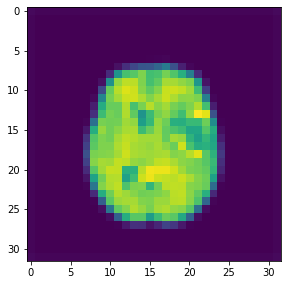

In [39]:

import random as r
i = int(r.random() * x.shape[0])
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(x[i, int(x.shape[1]/2), :, :, 0])


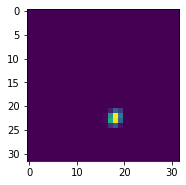

In [40]:
plt.subplot(122)
plt.imshow(y[i, int(y.shape[1]/2), :, :, 0])
plt.show()

In [41]:
model = UNet_3D(x.shape[1:], dim=16, factor=1)


In [42]:
model.load_weights('/content/weights.h5')


In [43]:
model.compile(optimizer=Adam(lr=0.000001), loss=f1_loss)


In [44]:
model.fit(x, y, validation_split=0.2, epochs=1, batch_size=8)


1/1 [==============================] - 32s 32s/step - loss: -0.0434 - val_loss: -0.4527


In [45]:
model.save_weights('weights.h5')


In [46]:
pred = model.predict(x[:50])


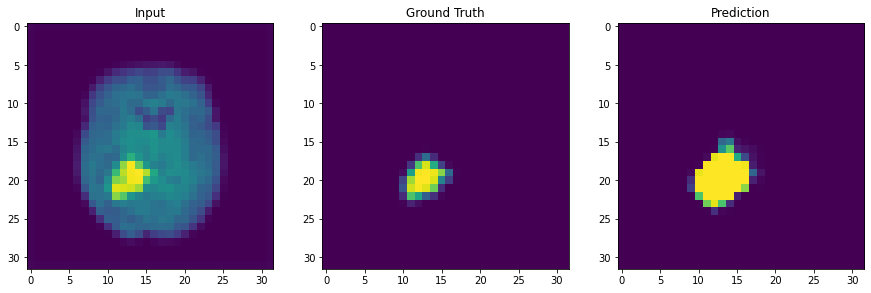

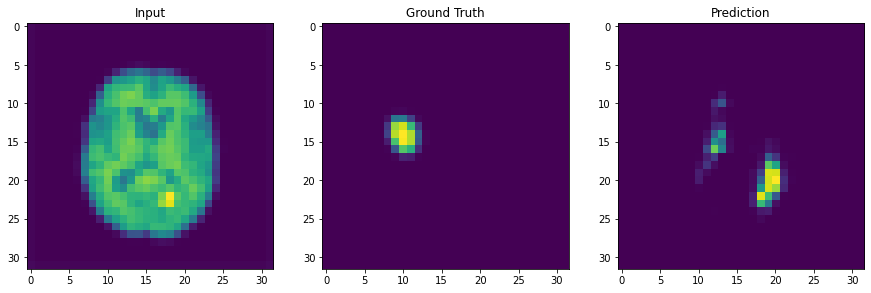

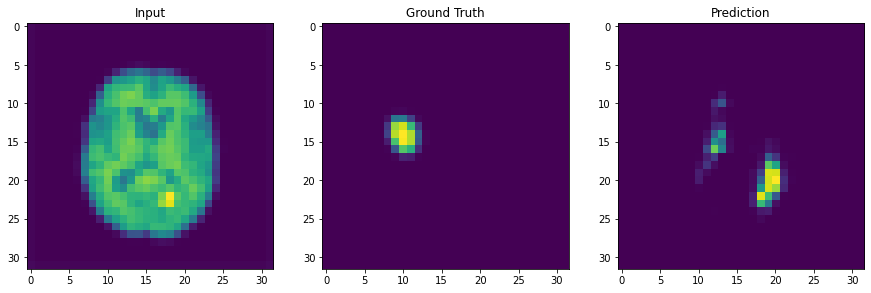

In [47]:
import random as r
num = int(x.shape[1]/2)
for n in range(3):
    i = int(r.random() * pred.shape[0])
    plt.figure(figsize=(15,10))

    plt.subplot(131)
    plt.title('Input')
    plt.imshow(x[i, num, :, :, 0])

    plt.subplot(132)
    plt.title('Ground Truth')
    plt.imshow(y[i, num, :, :, 0])

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(pred[i, num, :, :, 0])

    plt.show()